In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [ ]:
def random_initialization(n_components, n_features, random_state=None):
    np.random.seed(random_state)
    
    pi = np.random.dirichlet(alpha=np.ones(n_components))
    mu = np.random.randn(n_components, n_features) * n_components  # Random means with larger spread
    
    # Initialize covariance matrices to be positive semidefinite
    sigma = []
    for _ in range(n_components):
        A = np.random.randn(n_features, n_features)
        cov_matrix = np.dot(A, A.T)  # Creating a symmetric positive semidefinite matrix
        sigma.append(cov_matrix)
    sigma = np.array(sigma)
    
    return pi, mu, sigma


def compute_responsibilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_responsibilities = np.zeros(K)
    
    for k in range(K):
        diff = x - mu[k]
        
        # Add small constant to diagonal for numerical stability
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])
        
        # Compute log probability in a numerically stable way
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_responsibilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))
    
    # Subtract maximum for numerical stability
    log_responsibilities -= np.max(log_responsibilities)
    responsibilities = np.exp(log_responsibilities)
    responsibilities /= np.sum(responsibilities)
    
    return responsibilities

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6, eps=1e-10):
    # Compute mixing coefficients with minimum probability
    pi = np.maximum(mu_stats['N'], eps)
    pi = pi / np.sum(pi)
    
    # Compute means with safety check
    safe_N = np.maximum(mu_stats['N'], eps)[:, None]
    mu = mu_stats['sum_x'] / safe_N
    
    # Compute covariances
    sigma = []
    for k in range(len(pi)):
        safe_N_k = max(mu_stats['N'][k], eps)
        cov = mu_stats['sum_xx'][k] / safe_N_k - np.outer(mu[k], mu[k])
        # Ensure symmetry
        cov = (cov + cov.T) / 2
        # Add regularization to diagonal
        cov.flat[::len(cov) + 1] += reg_covar
        # Ensure positive definiteness
        min_eig = np.min(np.linalg.eigvals(cov))
        if min_eig < 0:
            cov.flat[::len(cov) + 1] -= min_eig - eps
        sigma.append(cov)
    
    return pi, mu, np.array(sigma)


def online_incremental_em_gmm(X, n_components=3, T=10, random_state=None, tol=1e-8):
    n_samples, n_features = X.shape
    
    # Initialize parameters without accessing full dataset
    pi, mu, sigma = random_initialization(n_components, n_features, random_state)
    
    mu_history = [mu.copy()]
    prev_log_likelihood = -np.inf
    
    # Main EM iterations
    for t in range(T):
        current_log_likelihood = 0
        
        # Initialize sufficient statistics for this epoch
        mu_stats = {
            'N': np.zeros(n_components),
            'sum_x': np.zeros((n_components, n_features)),
            'sum_xx': np.zeros((n_components, n_features, n_features))
        }
        
        # Process all samples
        for idx in range(n_samples):
            x_i = X[idx]
            
            # E-step: Compute responsibilities for current sample
            gamma = compute_responsibilities(x_i, pi, mu, sigma)
            
            # Update sufficient statistics with current sample
            mu_stats['N'] += gamma
            mu_stats['sum_x'] += gamma[:, None] * x_i
            for k in range(n_components):
                mu_stats['sum_xx'][k] += gamma[k] * np.outer(x_i, x_i)
            
            # M-step: Update parameters after each sample
            pi, mu, sigma = compute_parameters(mu_stats, idx + 1)
            
            current_log_likelihood += np.log(np.sum(gamma))
        
        # Track cluster centers at the end of each epoch
        mu_history.append(mu.copy())
        
        # Check convergence
        if abs(current_log_likelihood - prev_log_likelihood) < tol:
            print(f"Converged at iteration {t}")
            break
            
        prev_log_likelihood = current_log_likelihood
    
    return pi, mu, sigma, np.array(mu_history)


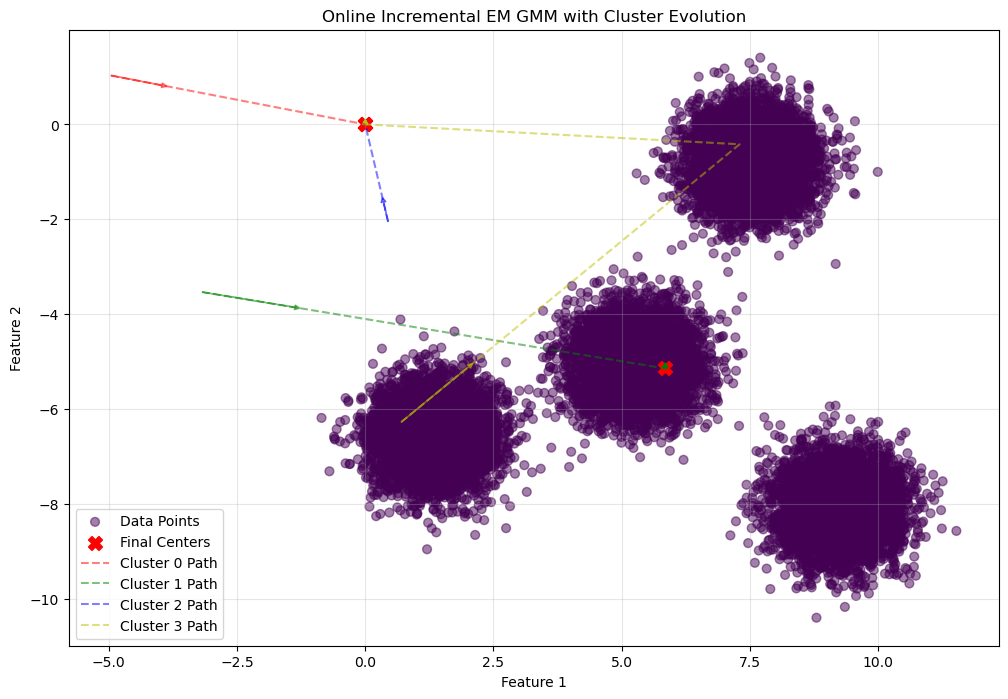

In [37]:
def plot_cluster_evolution(X, labels, mu_history, mu_final, true_centers=None):
    plt.figure(figsize=(12, 8))
    
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', alpha=0.5, label='Data Points')
    
    # Plot true centers if provided
    if true_centers is not None:
        plt.scatter(true_centers[:, 0], true_centers[:, 1], c='black', s=200, marker='*', 
                   label='True Centers')
    
    # Plot final cluster centers
    plt.scatter(mu_final[:, 0], mu_final[:, 1], c='red', s=100, marker='X', 
               label='Final Centers')
    
    # Plot cluster center trajectories
    colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Add more colors if needed
    for k in range(mu_history.shape[1]):
        trajectory = mu_history[:, k, :]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 
                c=colors[k % len(colors)], 
                linestyle='--', 
                linewidth=1.5,
                alpha=0.5,
                label=f'Cluster {k} Path')
        
        # Add arrows to show direction
        for i in range(len(trajectory)-1):
            if i % 2 == 0:  # Add arrows every other step to avoid clutter
                plt.arrow(trajectory[i, 0], trajectory[i, 1],
                         (trajectory[i+1, 0] - trajectory[i, 0])*0.2,
                         (trajectory[i+1, 1] - trajectory[i, 1])*0.2,
                         head_width=0.1, head_length=0.1, fc=colors[k % len(colors)],
                         ec=colors[k % len(colors)], alpha=0.5)
    
    plt.title('Online Incremental EM GMM with Cluster Evolution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    # Generate synthetic data
    n_samples = 20000
    n_components = 4
    random_state = 1126
    
    # Generate data with known centers
    X, y_true = make_blobs(n_samples=n_samples, 
                          centers=n_components,
                          cluster_std=0.6,
                          random_state=random_state)
    
    # Run Online Incremental EM
    T = 15
    pi, mu_k, sigma_k, mu_history = online_incremental_em_gmm(X, 
                                                             n_components=n_components, 
                                                             T=T, 
                                                             random_state=random_state)
    
    # Assign clusters
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        probs = compute_responsibilities(X[i], pi, mu_k, sigma_k)
        labels[i] = np.argmax(probs)
    
    # Plot results with cluster evolution
    plot_cluster_evolution(X, labels, mu_history, mu_k)

In [ ]:
# if __name__ == "__main__":
#     # Generate synthetic data
#     X, y_true = make_blobs(n_samples=20000, centers=4, cluster_std=0.60, random_state=1126)
    
#     # Run Online Incremental EM
#     n_components = 4
#     T = 1
#     random_state = 42
#     pi, mu_k, sigma_k = online_incremental_em_gmm(X, n_components=n_components, 
#                                                  T=T, random_state=random_state)
    
#     # Assign clusters
#     labels = np.zeros(X.shape[0], dtype=int)
#     for i in range(X.shape[0]):
#         probs = compute_responsibilities(X[i], pi, mu_k, sigma_k)
#         labels[i] = np.argmax(probs)
    
#     # Plot results
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', 
#                 label='Data Points')
#     plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', 
#                 label='Cluster Centers')
#     plt.title('Online Incremental EM Gaussian Mixture Model')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.legend()
#     plt.show()


ValueError: too many values to unpack (expected 3)